In [2]:
#import shit

import numpy as np
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import itertools

In [3]:
#methods to read data

def get_umi_counts(inf):
    umi_counts = {}
    with open(inf) as reader:
        header = reader.readline()
        for line in reader:
            (kmer, count) = line.strip().split('\t')
            umi_counts[kmer] = int(count)
    return umi_counts

def get_read_data(inf):
    read_data = {}
    with open(inf) as reader:
        header = reader.readline()    
        for line in reader:
            data = line.strip().split('\t')
            kmer = data[0]
            count = int(data[1])
            num_mismatches = int(data[2])
            
            if(num_mismatches > 0):
                mismatches = [int(i) for i in data[3].split(',')]
            else:
                mismatches = []
            read_data[kmer] = (count, num_mismatches, mismatches)
    return read_data

def get_common_data(data_1, data_2):
    """
    Compares read counts, outputs dict[kmer] = tup (data1, data2)
    """
    
    common_data = {}
    for (key, val) in data_1.items():
        if(key in data_2.keys()):
            common_data[key] = (
                val, data_2[key]
            )
    return common_data 

def get_nucleotide_per_position(read_data):
    """
    read data is a dict of tuple
    read_data[kmer] = (count, num_mismatches, mismatches)
    """
    alphabet = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}
    key, _ = read_data.popitem()
    read_len = len(key)
    nuc_per_pos = np.zeros((5, read_len))
    
    for (kmer, data) in read_data.items():
        (count, _, _) = data
        for (i, nuc) in enumerate(kmer):
            if(nuc in alphabet.keys()):
                x = alphabet[nuc]
                nuc_per_pos[x, i] += count
    return nuc_per_pos

def get_mismatch_per_position(read_data):
    """
    read data is a dict of tuple
    read_data[kmer] = (count, num_mismatches, mismatches)
    """
    alphabet = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}
    key, _ = read_data.popitem()
    read_len = len(key)
    mismatch_per_pos = np.zeros((5, read_len))
    
    for (kmer, data) in read_data.items():
        (count, _, mismatches) = data
        for m in mismatches:
            wrong_base = kmer[m]
            if(wrong_base != 'N'):
                x = alphabet[wrong_base]
                mismatch_per_pos[x, m] += count
    return mismatch_per_pos   

def get_pairwise_mismatch_matrix(reads):
    key, _ = reads.popitem()
    read_len = len(key)
    mismatch_pairs = np.zeros((read_len, read_len))
    alphabet = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    for (kmer, data) in reads.items():
        (count, num_mismatches, mismatches) = data
        if(num_mismatches >= 2):
            for(a,b) in itertools.combinations(mismatches, 2):
                if(kmer[a] in 'AGCT' and kmer[b] in 'AGCT'):
                    #mm_1 = alphabet[kmer[a]]
                    #mm_2 = alphabet[kmer[b]]
                    #index_1 = 4*a + mm_1
                    #index_2 = 4*b + mm_2
                    i1 = a
                    i2 = b
                    mismatch_pairs[i1, i2] += count
                    mismatch_pairs[i2, i1] += count
    return mismatch_pairs

In [4]:
#methods to plot summary data from one data set

def plot_umi_hist(umi_counts):
    #x axis: number of observations of a UMI (binned)
    #y axis: number of UMIs in given bin
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
    data = list(umi_counts.values())
    bins = np.logspace(0, 5, 25)
    hist, bin_edges = np.histogram(data, bins=bins)
    ax.step(bins[0:-1], hist)
    ax.set_xlabel('Number of observations of given UMI')
    ax.set_ylabel('Number of UMIs')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('UMI counts histogram')
    plt.tight_layout()

    
def plot_reads_hist(read_data):
    #x axis: number of observations of a read sequence (binned)
    #y axis: number of deduplicated reads in a given bin
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
    data = [tup[0] for tup in list(read_data.values())]

    bins = np.arange(0, 2000, 100)
    hist, bin_edges = np.histogram(data, bins=bins)
    ax.step(bins[0:-1], hist)
    ax.set_yscale('log')
    ax.set_xlabel('Number of observations of a given read seq')
    ax.set_ylabel('Number of read seqs')
    ax.set_title('Reads counts histogram')
    plt.tight_layout()

    
def plot_mismatch_vs_pos(data):
    #x axis: position along read
    #y axis: mismatch frequency
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    
    x = range(0, len(data))
    ax.step(x, data)
    ax.set_xlabel('Position')
    ax.set_ylabel('Num reads')
    ax.set_title('Mismatch counts by position')
    plt.tight_layout()
    
    
def plot_counts_v_mismatches(read_data):
    #scatter plot, x: number of observations of read seq; y: number of mismatches

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
    
    x = [tup[0] for tup in list(read_data.values())]
    y = [tup[1] for tup in list(read_data.values())]
    ax.scatter(x, y, alpha = 0.01)
    ax.set_xscale('log')
    ax.set_xlabel('Number of read observations')
    ax.set_ylabel('Number of mismatches in read')
    ax.set_title('Mismatches vs read counts')
    plt.tight_layout()    

In [5]:
#pairwise comparisons between two datasets

def get_pairwise_mismatch_matrix(reads):
    key, _ = reads.popitem()
    read_len = len(key)
    mismatch_pairs = np.zeros((read_len, read_len))
    alphabet = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    for (kmer, data) in reads.items():
        (count, num_mismatches, mismatches) = data
        if(num_mismatches >= 2):
            for(a,b) in itertools.combinations(mismatches, 2):
                if(kmer[a] in 'AGCT' and kmer[b] in 'AGCT'):
                    #mm_1 = alphabet[kmer[a]]
                    #mm_2 = alphabet[kmer[b]]
                    #index_1 = 4*a + mm_1
                    #index_2 = 4*b + mm_2
                    i1 = a
                    i2 = b
                    mismatch_pairs[i1, i2] += count
                    mismatch_pairs[i2, i1] += count
    return mismatch_pairs

def plot_pairwise(mm):
    """
    plots a 2d miatrix as heatmap
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.imshow(mm, interpolation='nearest')

In [6]:
#read input data for sample A
sample_a = './Deduplicated/outputs/JDMO002A_S1/'

#read input data for sample B
sample_b = './Deduplicated/outputs/JDMO002N_S14/'

In [7]:
a_umi = get_umi_counts(sample_a + 'umi_counts.txt')
a_reads = get_read_data(sample_a + 'read_counts.txt')
a_nuc_per_pos = get_nucleotide_per_position(a_reads)
a_mismatch_per_pos = get_mismatch_per_position(a_reads)
a_pairwise_mismatch = get_pairwise_mismatch_matrix(a_reads)

b_umi = get_umi_counts(sample_b + 'umi_counts.txt')
b_reads = get_read_data(sample_b + 'read_counts.txt')
b_nuc_per_pos = get_nucleotide_per_position(b_reads)
b_mismatch_per_pos = get_mismatch_per_position(b_reads)
b_pairwise_mismatch = get_pairwise_mismatch_matrix(b_reads)

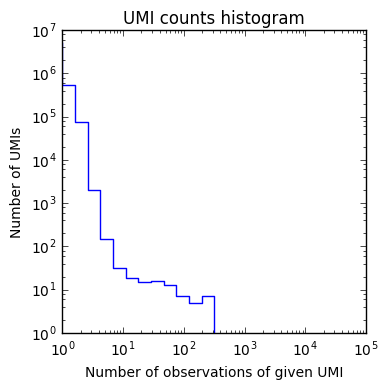

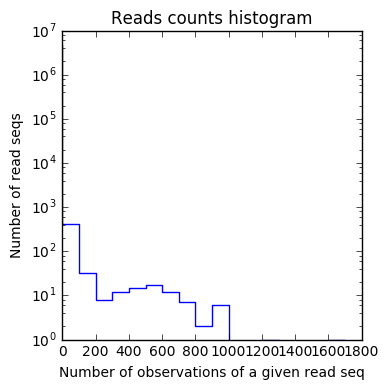

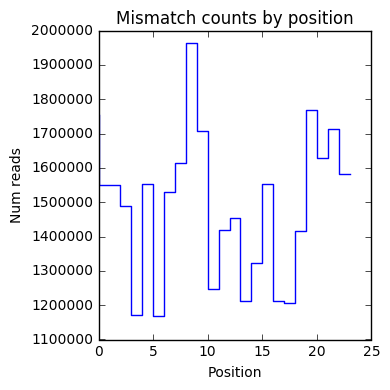

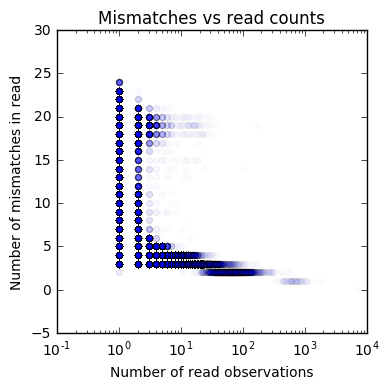

In [8]:
#plot 1-D data summaries for sample A

plot_umi_hist(a_umi)
plot_reads_hist(a_reads)
plot_mismatch_vs_pos(
    np.sum(a_mismatch_per_pos, axis=0)
)
plot_counts_v_mismatches(a_reads)


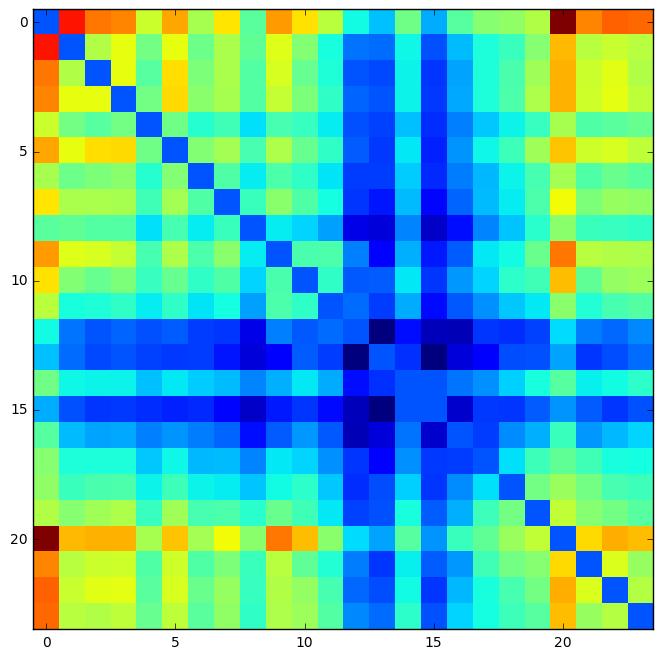

In [9]:
#get pairwise data
#common_data = get_common_data(a_reads, b_reads)
plot_pairwise(b_pairwise_mismatch - a_pairwise_mismatch)

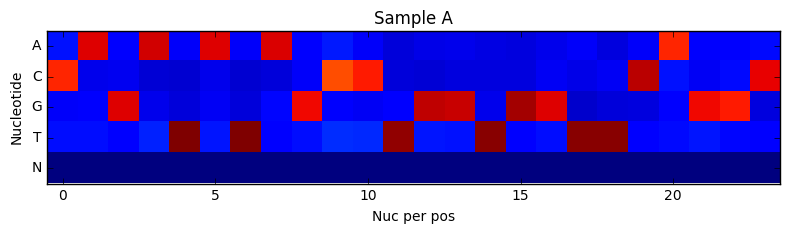

In [21]:
def plot_per_position_hmap(per_pos, title='DEFAULT'):  
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
    ax.imshow(per_pos, interpolation='nearest')
    ax.set_ylabel('Nucleotide')
    ax.set_yticklabels(['', 'A', 'C', 'G', 'T', 'N'])
    ax.set_xlabel('Nuc per pos')
    ax.set_title(title)
    plt.tight_layout()

plot_per_position_hmap(
    a_nuc_per_pos,
    title = 'Sample A')